# EDA y Preprocesamiento de Letras de Canciones

Esta sección del notebook realiza el análisis exploratorio de datos (EDA) y el preprocesamiento de las letras de canciones contenidas en el CSV.  
Las tareas incluyen:  
- Carga y verificación de información básica del dataset.  
- Análisis de la distribución de clases (tags) y artistas más comunes.  
- Análisis de la longitud de las letras.  
- Visualización con gráficas (countplots, histogramas y WordCloud).  
- Preprocesamiento del texto: limpieza (minúsculas, eliminación de URLs, etiquetas, puntuación, etc.), tokenización, eliminación de stopwords y lematización.


In [1]:
# Importaciones generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

# Configuración de gráficos
sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.rcParams["figure.figsize"] = (10,6)

# Descarga de recursos de NLTK (si no se han descargado aún)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Cargar modelo de spaCy
# nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fdezc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fdezc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fdezc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fdezc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

C:\Users\fdezc\AppData\Local\Temp\ipykernel_8884\680509456.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_ini.groupby('tag').apply(lambda x: x.sample(frac=0.005, random_state=42)).reset_index(drop=True)


Primeras 5 filas:
                         title  tag            artist  year  \
0  Me And The Boys In The Band  pop  Carly Rae Jepsen  2020   
1                 Closed Doors  pop         Amber Liu  2018   
2               Untamed Region  pop        Jenny Hval  2016   
3                   Everything  pop      Diamond Eyes  2018   
4                       Lentil  pop               Sia  2008   

                                              lyrics  views   rank  
0  [Verse 1]\nOn the road for half the year\nAnd ...   3704  71788  
1  [Verse 1]\nHold me like you did before\nDon't ...   4042  67219  
2  [Intro]\nIt sums up the strange mood of our ti...   5375  54067  
3  [Verse 1]\nI'm on my own, broke and alone\nI f...  63565   7169  
4  [Verse 1]\nOh, you were waiting for me, you sa...  11593  29619  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  ------

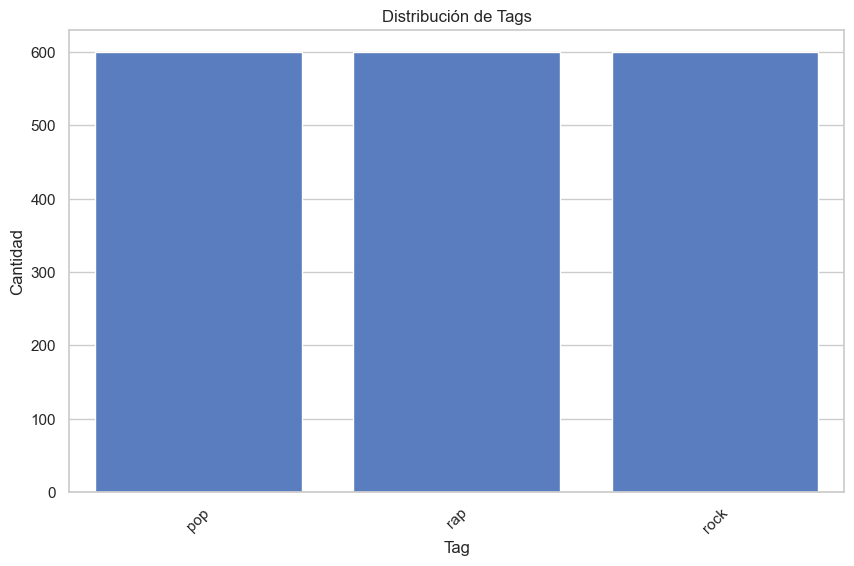


Top 10 Artistas:
artist
Genius English Translations    19
Rick Ross                       5
Bob Dylan                       5
Green Day                       4
2Pac                            4
Logic                           4
Katy Perry                      4
Yelawolf                        4
Future                          4
Radiohead                       4
Name: count, dtype: int64


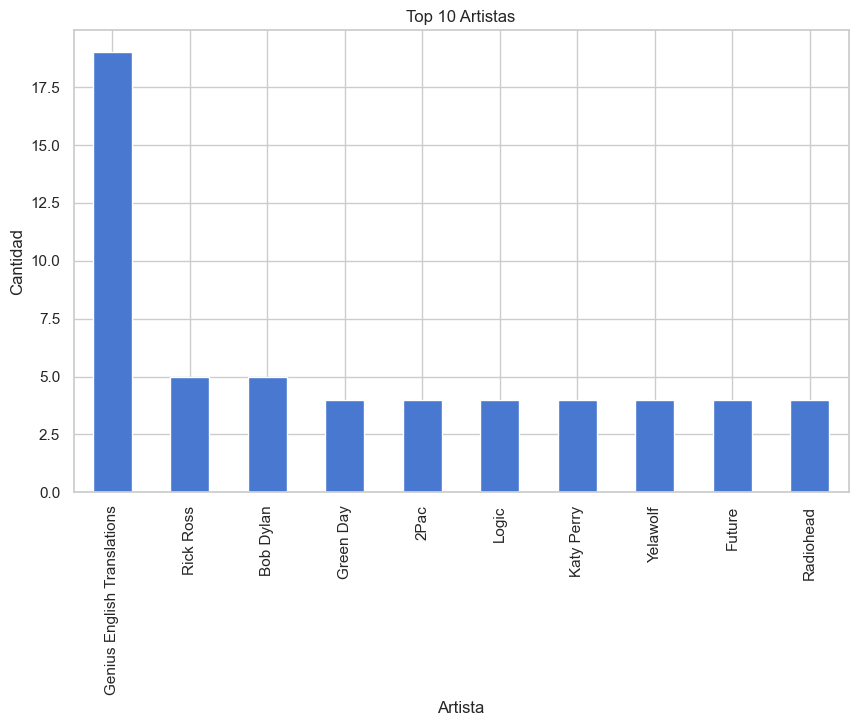

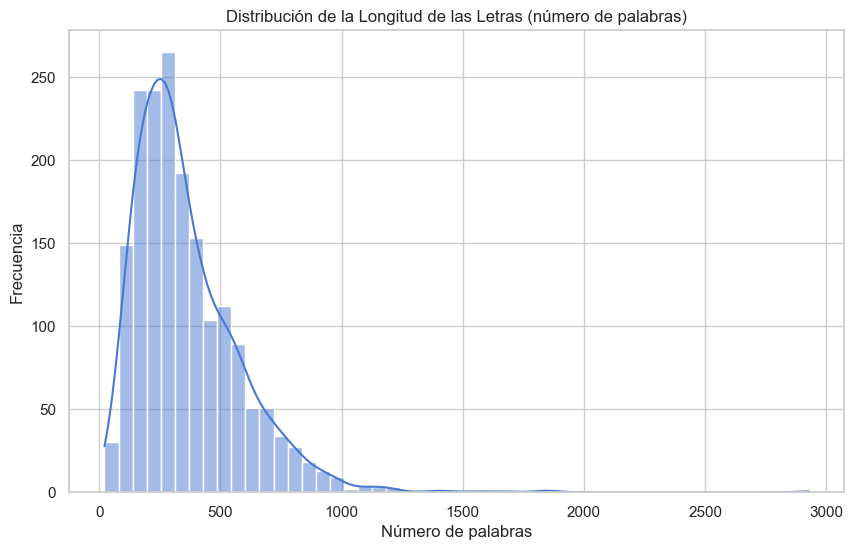

In [2]:
# Cargar el archivo CSV (ajusta la ruta si es necesario)
df_ini = pd.read_csv("data/genius_song_lyrics.csv")
df = df_ini.groupby('tag').apply(lambda x: x.sample(frac=0.005, random_state=42)).reset_index(drop=True)

# Mostrar las primeras filas para verificar la carga
print("Primeras 5 filas:")
print(df.head())

# Información general sobre el DataFrame
print("\nInformación del DataFrame:")
print(df.info())

# Comprobar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Distribución de las clases (tags)
print("\nDistribución de Tags:")
print(df['tag'].value_counts())

# Visualización: Count plot de los tags
sns.countplot(x='tag', data=df, order=df['tag'].value_counts().index)
plt.title("Distribución de Tags")
plt.xlabel("Tag")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.show()

# Top 10 artistas más comunes
print("\nTop 10 Artistas:")
print(df['artist'].value_counts().head(10))

# Visualización: Top 10 artistas
df['artist'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Artistas")
plt.xlabel("Artista")
plt.ylabel("Cantidad")
plt.show()

# Análisis de la longitud de las letras (número de palabras)
df['lyric_length'] = df['lyrics'].astype(str).apply(lambda x: len(x.split()))
sns.histplot(df['lyric_length'], bins=50, kde=True)
plt.title("Distribución de la Longitud de las Letras (número de palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()


In [3]:
# Configuramos expresiones regulares para optimizar el preprocesamiento
RE_SQUARE = re.compile(r"\[.*?\]")
RE_URL = re.compile(r"https?://\S+|www\.\S+")
RE_HTML = re.compile(r"<.*?>")
RE_PUNCT = re.compile(f"[{re.escape(string.punctuation)}]")
RE_NEWLINE = re.compile(r"\n+")

# Cargamos stopwords y el lematizador
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Dos versiones de funciones para la limpieza y tokenización de palabras:
# Versión usando NLTK
def clean_text_improved(text):
    """
    Limpia y normaliza el texto:
      - Convierte a minúsculas
      - Elimina contenido entre corchetes, URLs, etiquetas HTML y puntuación
      - Sustituye saltos de línea por espacios
      - Aplica tokenización con nltk.word_tokenize
      - Lematiza las palabras y elimina stopwords y tokens muy cortos (≤2 caracteres)
    """
    text = text.lower()
    text = RE_SQUARE.sub("", text)
    text = RE_URL.sub("", text)
    text = RE_HTML.sub("", text)
    text = RE_PUNCT.sub("", text)
    text = RE_NEWLINE.sub(" ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return " ".join(tokens)


# Versión usando SpaCy
def clean_text_spacy(text):
    """
    Limpia y normaliza el texto usando spaCy:
      - Convierte a minúsculas.
      - Elimina URLs y etiquetas HTML (usando regex).
      - Procesa con spaCy para tokenización y lematización.
      - Elimina tokens que sean stopwords, signos de puntuación o de longitud ≤2.
    """
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminación de URL y etiquetas HTML
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    
    # Procesar con spaCy
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Considerar token.is_stop para eliminar stopwords y token.is_punct para puntuación
        if token.is_stop or token.is_punct:
            continue
        # Filtrar tokens muy cortos
        if len(token.text.strip()) <= 2:
            continue
        tokens.append(token.lemma_)  # Usar la forma lematizada
    return " ".join(tokens)

In [4]:
# Separamos los dataframes en dos para evaluar NLTL vs SpaCy
df_NLTK = df.copy()
# df_SpaCy = df.copy()

print("Aplicando limpieza de texto en la columna 'lyrics'...")
df_NLTK['clean_lyrics'] = df_NLTK['lyrics'].astype(str).apply(clean_text_improved)

# Muestra algunas comparaciones entre texto original y texto limpio
print("\nCOMPARACIÓN TEXTO ORIGINAL VS LIMPIO USANDO NLTK:")
print("\nEjemplo de letra original (NLTK):")
print(df_NLTK['lyrics'].iloc[0][:300])  # Muestra los primeros 300 caracteres
print("\nEjemplo de letra limpia:")
print(df_NLTK['clean_lyrics'].iloc[0][:300])


Aplicando limpieza de texto en la columna 'lyrics'...

COMPARACIÓN TEXTO ORIGINAL VS LIMPIO USANDO NLTK:

Ejemplo de letra original (NLTK):
[Verse 1]
On the road for half the year
And I can't remember loneliness
And it feels like that says something about you
Or something 'bout me
Performance and the after party
And it took a little time I guess
But I found that I'm not thinking about you
Or thinking 'bout it

[Pre-Chorus]
Then we pack 

Ejemplo de letra limpia:
road half year cant remember loneliness feel like say something something bout performance party took little time guess found thinking thinking bout pack time well whole damn thing tomorrow new city pretty let driving night make show ill whole new girl tomorrow new city pretty eye closed partied str


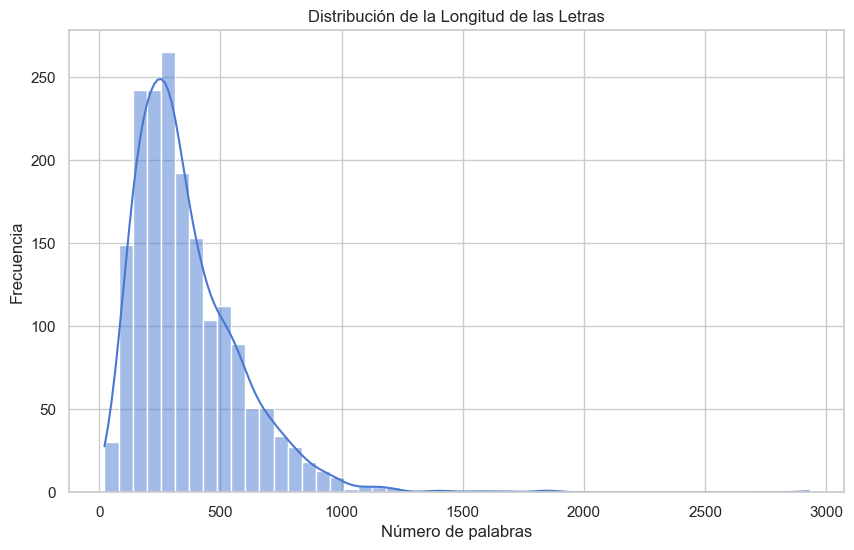

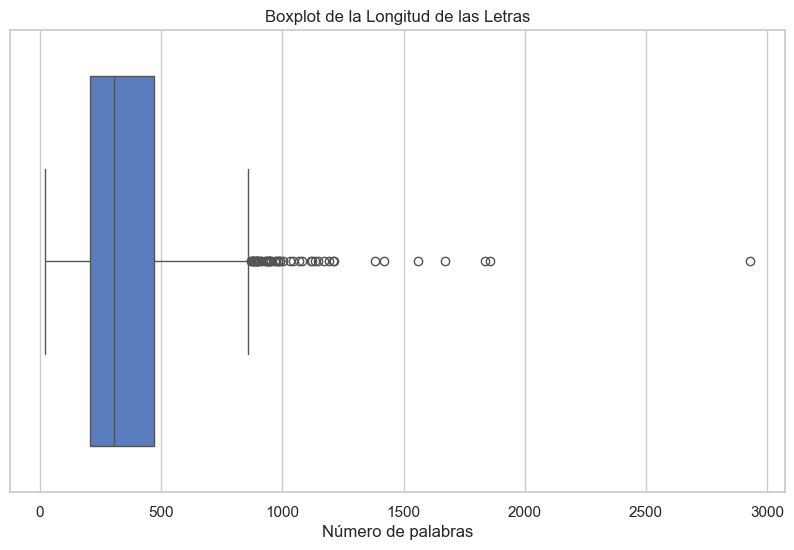

In [5]:
## A partir de este momento usamos el dataframe df_NLTK
# Calcular la longitud de cada letra (número de palabras después de la limpieza)
df_NLTK['lyric_length'] = df_NLTK['clean_lyrics'].apply(lambda x: len(x.split()))

# Histograma de la longitud de las letras
sns.histplot(df['lyric_length'], bins=50, kde=True)
plt.title("Distribución de la Longitud de las Letras")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot para ver outliers en la longitud
sns.boxplot(x=df['lyric_length'])
plt.title("Boxplot de la Longitud de las Letras")
plt.xlabel("Número de palabras")
plt.show()


20 palabras más frecuentes:
like: 4945
got: 4101
know: 3838
dont: 3636
yeah: 3156
get: 3073
love: 2754
nigga: 2422
time: 1936
one: 1869
bitch: 1834
aint: 1812
see: 1790
never: 1722
youre: 1693
cause: 1677
make: 1674
man: 1670
let: 1659
come: 1620


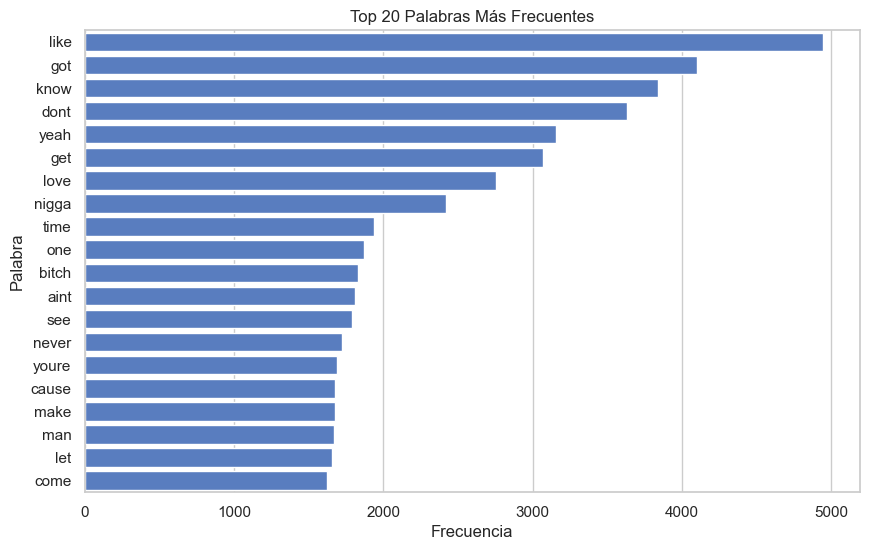

In [6]:
# Obtener todas las palabras del corpus
all_words = " ".join(df_NLTK['clean_lyrics']).split()
word_freq = Counter(all_words)

# Mostrar las 20 palabras más frecuentes
most_common = word_freq.most_common(20)
print("20 palabras más frecuentes:")
for word, freq in most_common:
    print(f"{word}: {freq}")

# Gráfica de barras de las 20 palabras más comunes
words, freqs = zip(*most_common)
sns.barplot(x=list(freqs), y=list(words), orient="h")
plt.title("Top 20 Palabras Más Frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()


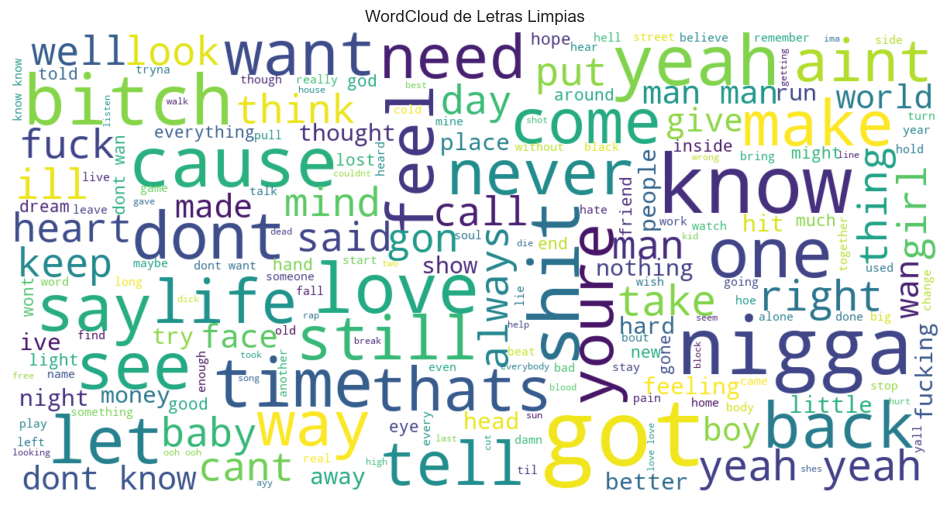

In [7]:
# Generar una cadena única con todo el contenido de la columna
all_lyrics = " ".join(df_NLTK['clean_lyrics'].values)

# Generar el WordCloud a partir de esa cadena única
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color='white', max_words=200, max_font_size=40, scale=3).generate(all_lyrics)
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Letras Limpias")
plt.show()


# Feature Engineering y ML Clásico

En esta sección se utilizará el corpus ya preprocesado (usando NLTK) para:
- Representar las letras mediante TF-IDF (incluyendo unigrams y bigrams).
- Dividir el dataset en conjuntos de entrenamiento y prueba.
- Entrenar un clasificador clásico (Multinomial Naive Bayes).
- Evaluar el rendimiento mediante classification report y matriz de confusión.
- Calcular y visualizar la learning curve (curva de entrenamiento y validación) para analizar la evolución de la accuracy.


In [8]:
# Prueba reduciendo el tamaño del dataset a la mitad
# Suponiendo que 'df' es tu DataFrame original y 'tag' es la columna de etiquetas
# df_NLTK_half = df_NLTK.groupby('tag').apply(lambda x: x.sample(frac=0.5, random_state=42)).reset_index(drop=True)
# df_NLTK_half = df_NLTK.groupby('tag', include_groups=False).apply(lambda x: x.sample(frac=0.5, random_state=42)).reset_index(drop=True)



In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear el vectorizador TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Ajustar y transformar el corpus preprocesado (usando NLTK)
# Se asume que en la columna 'clean_lyrics' ya tienes el texto limpio
X_tfidf = tfidf.fit_transform(df_NLTK['clean_lyrics'])

# Veamos la forma de la matriz resultante
print("Dimensiones de la matriz TF-IDF:", X_tfidf.shape)


Dimensiones de la matriz TF-IDF: (1800, 5000)


In [9]:
from sklearn.model_selection import train_test_split

# Suponiendo que la columna 'tag' es la etiqueta de la clase
y = df_NLTK['tag']

# Dividir el dataset en entrenamiento y prueba (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)


Tamaño de entrenamiento: (1440, 5000)
Tamaño de prueba: (360, 5000)


In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Crear y entrenar el modelo
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred = nb_model.predict(X_test)

# Imprimir reporte de clasificación
print("Reporte de Clasificación para Multinomial Naive Bayes:")
print(classification_report(y_test, y_pred))

# Imprimir matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)


Reporte de Clasificación para Multinomial Naive Bayes:
              precision    recall  f1-score   support

         pop       0.61      0.44      0.51       120
         rap       0.82      0.94      0.88       120
        rock       0.58      0.66      0.62       120

    accuracy                           0.68       360
   macro avg       0.67      0.68      0.67       360
weighted avg       0.67      0.68      0.67       360

Matriz de Confusión:
[[ 53  13  54]
 [  4 113   3]
 [ 30  11  79]]


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Creamos un pipeline que une TF-IDF y el clasificador
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', MultinomialNB())
])

# Definimos un diccionario de hiperparámetros
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__alpha': [0.1, 1.0, 10]
}

# Ejecutamos GridSearchCV con validación cruzada
grid_cv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_cv.fit(df_NLTK['clean_lyrics'], df_NLTK['tag'])

print("Mejores parámetros encontrados:", grid_cv.best_params_)
print("Mejor puntuación CV:", grid_cv.best_score_)


Mejores parámetros encontrados: {'clf__alpha': 1.0, 'tfidf__ngram_range': (1, 1)}
Mejor puntuación CV: 0.6644444444444445


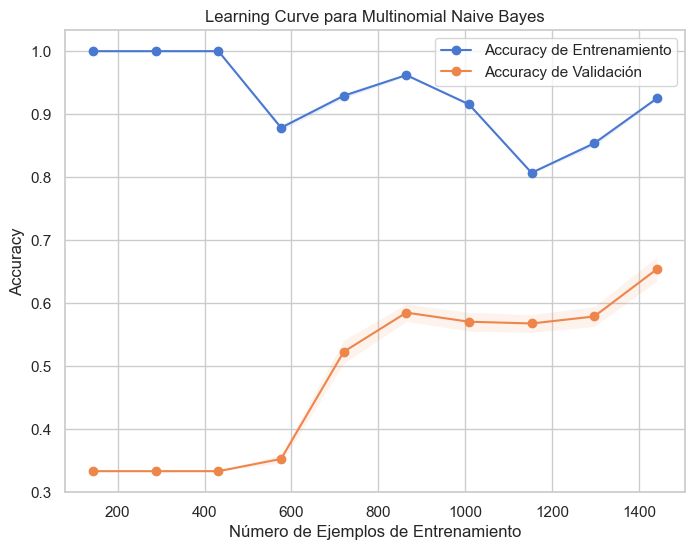

In [12]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Usamos el pipeline definido anteriormente para extraer la learning curve
train_sizes, train_scores, cv_scores = learning_curve(
    pipeline, df_NLTK['clean_lyrics'], df_NLTK['tag'],
    cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculamos las medias y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
cv_mean = np.mean(cv_scores, axis=1)
cv_std = np.std(cv_scores, axis=1)

# Graficamos la curva
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Accuracy de Entrenamiento")
plt.plot(train_sizes, cv_mean, 'o-', label="Accuracy de Validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha=0.1)
plt.xlabel("Número de Ejemplos de Entrenamiento")
plt.ylabel("Accuracy")
plt.title("Learning Curve para Multinomial Naive Bayes")
plt.legend(loc="best")
plt.show()


# Clasificación de Texto con Deep Learning

Esta sección implementa un clasificador de texto que utiliza Deep Learning. Se convierte el texto preprocesado (columna "clean_lyrics") en secuencias numéricas usando Keras Tokenizer y se construye un modelo LSTM para predecir la etiqueta ("tag") de cada canción. Se incluyen además visualizaciones de las curvas de entrenamiento y la matriz de confusión.


In [13]:
# Importaciones para ML clásico y DL
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10,6)


In [15]:
# Parámetros para la tokenización y el padding
max_words = 10000      # Número máximo de palabras a considerar
maxlen = 300           # Longitud máxima de cada secuencia

# Crear y ajustar el Tokenizer sobre el corpus preprocesado (columna "clean_lyrics")
tokenizer_dl = Tokenizer(num_words=max_words)
tokenizer_dl.fit_on_texts(df_NLTK['clean_lyrics'])

# Convertir los textos en secuencias numéricas
sequences = tokenizer_dl.texts_to_sequences(df_NLTK['clean_lyrics'])

# Aplicar padding para que todas las secuencias tengan la misma longitud
X_dl = pad_sequences(sequences, padding='post', maxlen=maxlen)

print("Dimensiones del array de secuencias:", X_dl.shape)


Dimensiones del array de secuencias: (1800, 300)


In [16]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_NLTK['tag'])
num_classes = len(encoder.classes_)
print("Número de clases:", num_classes)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Tamaño del conjunto de entrenamiento (DL):", X_train_dl.shape)
print("Tamaño del conjunto de prueba (DL):", X_test_dl.shape)


Número de clases: 3
Tamaño del conjunto de entrenamiento (DL): (1440, 300)
Tamaño del conjunto de prueba (DL): (360, 300)


In [17]:
# model_dl = Sequential([
#     Embedding(input_dim=max_words, output_dim=32, input_length=maxlen),
#     LSTM(32, dropout=0.3, recurrent_dropout=0.3),
#     Dropout(0.5),
#     Dense(32, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])

model_dl = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=maxlen),
    LSTM(64),  # Una capa LSTM simple con 32 unidades
    Dense(num_classes, activation='softmax')  # Capa de salida para 3 clases
])

# model_dl.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dl.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Resumen del Modelo LSTM:")
model_dl.summary()

# history_dl = model_dl.fit(
#     X_train_dl, y_train_dl,
#     epochs=5,
#     batch_size=64,
#     validation_data=(X_test_dl, y_test_dl),
#     callbacks=[early_stop]
# )

history_dl = model_dl.fit(
    X_train_dl, y_train_dl,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_dl, y_test_dl)
)


Resumen del Modelo LSTM:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 673,219
Trainable params: 673,219
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 6s 177ms/step - loss: 1.0924 - accuracy: 0.4201 - val_loss: 0.9960 - val_accuracy: 0.4833
Epoch 2/5
23/23 [==============================] - 4s 158ms/step - loss: 0.9805 - accuracy: 0.4875 - val_loss: 0.9622 - val_accuracy: 0.4889
Epoch 3

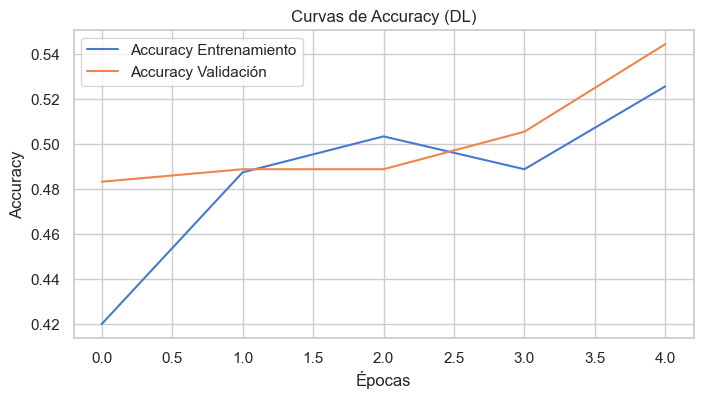

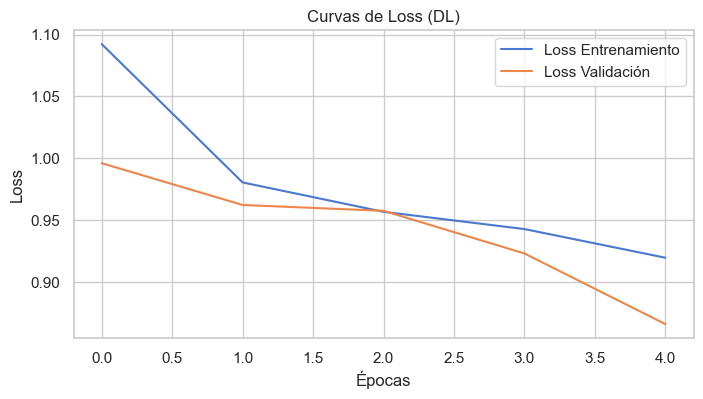

In [18]:
plt.figure(figsize=(8,4))
plt.plot(history_dl.history['accuracy'], label='Accuracy Entrenamiento')
plt.plot(history_dl.history['val_accuracy'], label='Accuracy Validación')
plt.title('Curvas de Accuracy (DL)')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_dl.history['loss'], label='Loss Entrenamiento')
plt.plot(history_dl.history['val_loss'], label='Loss Validación')
plt.title('Curvas de Loss (DL)')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()


12/12 [==============================] - 0s 29ms/step - loss: 0.8658 - accuracy: 0.5444
Test Loss (DL): 0.8658422827720642
Test Accuracy (DL): 0.5444444417953491
12/12 [==============================] - 1s 32ms/step
Reporte de Clasificación (DL):
              precision    recall  f1-score   support

           0       0.25      0.03      0.06       120
           1       0.80      0.66      0.72       120
           2       0.46      0.94      0.62       120

    accuracy                           0.54       360
   macro avg       0.50      0.54      0.47       360
weighted avg       0.50      0.54      0.47       360



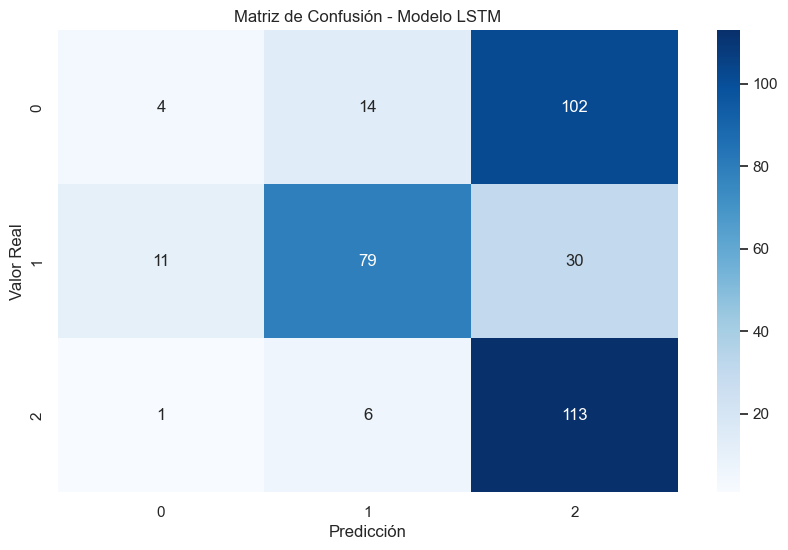

In [19]:
loss_dl, accuracy_dl = model_dl.evaluate(X_test_dl, y_test_dl)
print("Test Loss (DL):", loss_dl)
print("Test Accuracy (DL):", accuracy_dl)

y_pred_prob_dl = model_dl.predict(X_test_dl)
y_pred_dl = np.argmax(y_pred_prob_dl, axis=1)

print("Reporte de Clasificación (DL):")
print(classification_report(y_test_dl, y_pred_dl))

cm_dl = confusion_matrix(y_test_dl, y_pred_dl)
sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


# Transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
import torch
import pandas as pd
import numpy as np
import os

# Desactivar W&B
os.environ["WANDB_DISABLED"] = "true"

# 1. Carga de datos
df_class = df_NLTK[['clean_lyrics', 'tag']].dropna()

# 2. Sampleo de géneros (Se coge un conjunto de datos más pequeño para evitar problemas de memoria)
top_genres = sorted(df_class['tag'].unique()) 
df_class = df_class[df_class['tag'].isin(top_genres)]
df_class = df_class.sample(n=min(2000, len(df_class)), random_state=42)  # Ajusta el número según recursos disponibles
genre2id = {genre: i for i, genre in enumerate(top_genres)}
df_class['label'] = df_class['tag'].map(genre2id)



# 3. Split train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_class['clean_lyrics'].tolist(), df_class['label'].tolist(), test_size=0.2, random_state=42
)

# 4. Tokenizador
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 5. Crear datasets
train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
test_dataset = LyricsDataset(test_texts, test_labels, tokenizer)

# 6. Modelo preentrenado
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(genre2id)
)

# 7. Métricas de evaluación
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# 8. Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# 9. Entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 10. Entrenamiento
trainer.train()

# 11. Evaluación
trainer.evaluate()


c:\Users\fdezc\anaconda3\envs\AdneText\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\fdezc\anaconda3\envs\AdneText\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\fdezc\anaconda3\envs\AdneText\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifie

  0%|          | 0/1080 [00:00<?, ?it/s]

{'loss': 1.1454, 'learning_rate': 4.9537037037037035e-05, 'epoch': 0.03}
{'loss': 1.0619, 'learning_rate': 4.9074074074074075e-05, 'epoch': 0.06}
{'loss': 0.9084, 'learning_rate': 4.8611111111111115e-05, 'epoch': 0.08}
{'loss': 1.0879, 'learning_rate': 4.814814814814815e-05, 'epoch': 0.11}
{'loss': 0.8872, 'learning_rate': 4.768518518518519e-05, 'epoch': 0.14}
{'loss': 0.8981, 'learning_rate': 4.722222222222222e-05, 'epoch': 0.17}
{'loss': 0.9003, 'learning_rate': 4.675925925925926e-05, 'epoch': 0.19}
{'loss': 0.8492, 'learning_rate': 4.62962962962963e-05, 'epoch': 0.22}
{'loss': 0.7511, 'learning_rate': 4.5833333333333334e-05, 'epoch': 0.25}
{'loss': 0.7581, 'learning_rate': 4.5370370370370374e-05, 'epoch': 0.28}
{'loss': 0.8993, 'learning_rate': 4.490740740740741e-05, 'epoch': 0.31}
{'loss': 0.652, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.33}
{'loss': 0.8472, 'learning_rate': 4.3981481481481486e-05, 'epoch': 0.36}
{'loss': 0.8686, 'learning_rate': 4.351851851851852e-05, 'e

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.7326685786247253, 'eval_accuracy': 0.55, 'eval_precision': 0.5470561329039813, 'eval_recall': 0.55, 'eval_f1': 0.4599616173707452, 'eval_runtime': 27.3247, 'eval_samples_per_second': 13.175, 'eval_steps_per_second': 3.294, 'epoch': 1.0}
{'loss': 0.5718, 'learning_rate': 3.2870370370370375e-05, 'epoch': 1.03}
{'loss': 0.7359, 'learning_rate': 3.240740740740741e-05, 'epoch': 1.06}
{'loss': 0.666, 'learning_rate': 3.194444444444444e-05, 'epoch': 1.08}
{'loss': 0.5737, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}
{'loss': 0.8731, 'learning_rate': 3.101851851851852e-05, 'epoch': 1.14}
{'loss': 0.5766, 'learning_rate': 3.055555555555556e-05, 'epoch': 1.17}
{'loss': 0.7311, 'learning_rate': 3.0092592592592593e-05, 'epoch': 1.19}
{'loss': 0.6474, 'learning_rate': 2.962962962962963e-05, 'epoch': 1.22}
{'loss': 0.667, 'learning_rate': 2.916666666666667e-05, 'epoch': 1.25}
{'loss': 0.5337, 'learning_rate': 2.8703703703703706e-05, 'epoch': 1.28}
{'loss': 0.4088, 'learning

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.8726258277893066, 'eval_accuracy': 0.6055555555555555, 'eval_precision': 0.6413391489546932, 'eval_recall': 0.6055555555555555, 'eval_f1': 0.590274158447336, 'eval_runtime': 30.1891, 'eval_samples_per_second': 11.925, 'eval_steps_per_second': 2.981, 'epoch': 2.0}
{'loss': 0.4861, 'learning_rate': 1.6203703703703704e-05, 'epoch': 2.03}
{'loss': 0.4825, 'learning_rate': 1.574074074074074e-05, 'epoch': 2.06}
{'loss': 0.4865, 'learning_rate': 1.527777777777778e-05, 'epoch': 2.08}
{'loss': 0.4035, 'learning_rate': 1.4814814814814815e-05, 'epoch': 2.11}
{'loss': 0.3006, 'learning_rate': 1.4351851851851853e-05, 'epoch': 2.14}
{'loss': 0.1885, 'learning_rate': 1.388888888888889e-05, 'epoch': 2.17}
{'loss': 0.6513, 'learning_rate': 1.3425925925925928e-05, 'epoch': 2.19}
{'loss': 0.5283, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}
{'loss': 0.3989, 'learning_rate': 1.25e-05, 'epoch': 2.25}
{'loss': 0.4356, 'learning_rate': 1.2037037037037037e-05, 'epoch': 2.28}
{'loss'

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.9265968203544617, 'eval_accuracy': 0.6638888888888889, 'eval_precision': 0.681569366209804, 'eval_recall': 0.6638888888888889, 'eval_f1': 0.6679572945067507, 'eval_runtime': 32.0698, 'eval_samples_per_second': 11.226, 'eval_steps_per_second': 2.806, 'epoch': 3.0}
{'train_runtime': 1560.9011, 'train_samples_per_second': 2.768, 'train_steps_per_second': 0.692, 'train_loss': 0.6319992589729804, 'epoch': 3.0}


  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.9265968203544617,
 'eval_accuracy': 0.6638888888888889,
 'eval_precision': 0.681569366209804,
 'eval_recall': 0.6638888888888889,
 'eval_f1': 0.6679572945067507,
 'eval_runtime': 33.2127,
 'eval_samples_per_second': 10.839,
 'eval_steps_per_second': 2.71,
 'epoch': 3.0}

In [22]:
# 12. Reporte de métricas completo
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Diccionario invertido para etiquetas legibles
id2genre = {v: k for k, v in genre2id.items()}
target_names = [id2genre[i] for i in sorted(id2genre.keys())]

# Reporte de clasificación
report = classification_report(y_true, y_pred, target_names=target_names)
print("\n=== Métricas completas BERT ===")
print(report)


  0%|          | 0/90 [00:00<?, ?it/s]


=== Métricas completas BERT ===
              precision    recall  f1-score   support

         pop       0.62      0.55      0.58       142
         rap       0.89      0.78      0.83       115
        rock       0.53      0.69      0.60       103

    accuracy                           0.66       360
   macro avg       0.68      0.67      0.67       360
weighted avg       0.68      0.66      0.67       360



In [23]:
def predict_genre(text, model, tokenizer, genre2id, max_len=128):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_id = torch.argmax(probs, dim=1).item()
    id2genre = {v: k for k, v in genre2id.items()}
    predicted_genre = id2genre[pred_id]
    confidence = probs[0][pred_id].item()
    return predicted_genre, confidence

sample_lyrics = """
Got the beat up loud and the bassline heavy,
Party all night like I'm rollin' with Chevy.
Gold on my wrist, dreams in my head,
Livin' like a king, never sleep in my bed.
"""

genre, conf = predict_genre(sample_lyrics, model, tokenizer, genre2id)
print(f"Predicción: {genre} (confianza: {conf:.2f})")


Predicción: rock (confianza: 0.45)


## Q&A (Question Answering)

- Dada una letra al azar del dataset, el usuario podrá realizar preguntas sencillas a las cuales el modelo debería ser capaz de dar respuesta.

- Para el entrenamiento se ha usado un dataset generado sintéticamente de 100 registros con columnas **contexto**, **pregunta** y **respuesta**, siendo el contexto extractos de los lyrics del dataset original

In [24]:
# Entrenamiento de QA con Hugging Face sobre letras del dataset

from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
import torch

# 1. Cargar CSV de QA real generado previamente
qa_df = pd.read_csv("data\qa_dataset_lyrics_semicolon.csv", sep=';')

# 2. Convertir la columna 'answers' al formato requerido por Hugging Face
qa_df["answers"] = qa_df.apply(lambda row: {
    "text": [row["answer_text"]],
    "answer_start": [row["answer_start"]]
}, axis=1)

# 3. Crear Dataset compatible con Hugging Face
qa_dataset = Dataset.from_pandas(qa_df[["id", "context", "question", "answers"]])

# 4. Cargar modelo y tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")

# 5. Preprocesamiento para QA (estilo SQuAD)
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Detectar los límites del contexto
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # Asignar posición de la respuesta
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

# 6. Tokenización
tokenized_dataset = qa_dataset.map(preprocess_function, batched=True)

# 7. Configuración de entrenamiento
training_args = TrainingArguments(
    output_dir="./qa_lyrics_model",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_dir="./logs_qa",
    logging_steps=1,
    save_strategy="no"
)

# 8. Entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

# 9. Entrenar el modelo
trainer.train()

# 10. Función de inferencia para probar el modelo entrenado
def answer_question(question, context):
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    start = torch.argmax(outputs.start_logits)
    end = torch.argmax(outputs.end_logits) + 1
    tokens = inputs["input_ids"][0][start:end]
    return tokenizer.decode(tokens)


c:\Users\fdezc\anaconda3\envs\AdneText\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/18 [00:00<?, ?it/s]

{'loss': 5.0093, 'learning_rate': 4.722222222222222e-05, 'epoch': 0.17}
{'loss': 7.0253, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.33}
{'loss': 5.9423, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.5}
{'loss': 5.4395, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}
{'loss': 5.8526, 'learning_rate': 3.611111111111111e-05, 'epoch': 0.83}
{'loss': 5.2066, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}
{'loss': 4.1945, 'learning_rate': 3.055555555555556e-05, 'epoch': 1.17}
{'loss': 4.9442, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}
{'loss': 3.9728, 'learning_rate': 2.5e-05, 'epoch': 1.5}
{'loss': 3.4261, 'learning_rate': 2.2222222222222223e-05, 'epoch': 1.67}
{'loss': 4.0948, 'learning_rate': 1.9444444444444445e-05, 'epoch': 1.83}
{'loss': 4.3078, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}
{'loss': 1.6994, 'learning_rate': 1.388888888888889e-05, 'epoch': 2.17}
{'loss': 3.5539, 'learning_rate': 1.1111111111111112e-05, 'epoch': 2.33}
{'lo

In [25]:
# 1. Seleccionar letra aleatoria
import random
row = df.sample(1).iloc[0]
contexto = row["lyrics"]

# 2. Mostrar letra (recortada si es larga)
print("LETRA DE CANCIÓN:\n" + "-" * 60)
print(contexto[:800] + "..." if len(contexto) > 800 else contexto)
print("-" * 60)

# 3. Pedir pregunta al usuario
pregunta = input("Escribe tu pregunta sobre esta letra:\n> ")

# 4. Ejecutar el modelo de QA
inputs = tokenizer(pregunta, contexto, return_tensors="pt", truncation=True, padding=True)
with torch.no_grad():
    outputs = model(**inputs)
start = torch.argmax(outputs.start_logits)
end = torch.argmax(outputs.end_logits) + 1
respuesta = tokenizer.decode(inputs["input_ids"][0][start:end])

# 6. Mostrar respuesta
print(f"\n Pregunta: {pregunta}")
print(" Respuesta del modelo:", respuesta)

LETRA DE CANCIÓN:
------------------------------------------------------------
This beat is my recital
I think it's very vital
To rock a rhyme
That's right on time
It's tricky tricky yo here we go

It's tricky to rock a rhyme
To rock a rhyme that's right on time
It's tricky tricky tricky tricky tricky tricky

It's tricky to rock a rhyme
To rock a rhyme that's right on time
It's tricky tricky tricky tricky tricky tricky

I met this little girlie her hair was kind of curly
Went to her house to bust her out I had to leave real early
These girls are really sleazy all they just say is please me
To rock a rhyme that's right on time I said it's not that easy

It's tricky to rock a rhyme
To rock a rhyme that's right on time
It's tricky tricky tricky tricky tricky tricky
It's tricky to rock a rhyme
To rock a rhyme that's right on time
It's tricky tricky tricky tricky tricky t...
------------------------------------------------------------

 Pregunta: What is my recital?
 Respuesta del modelo: T

## Summarization

In [26]:
from transformers import pipeline
import pandas as pd

# 1. Cargar dataset y seleccionar letras 
df["lyrics"] = df["lyrics"].astype(str).apply(lambda x: re.sub(r"\[.*?\]", "", x))
df_sum = df[["lyrics"]].dropna().sample(100, random_state=42)  # Usamos 100 muestras para no reventar

# 2. Cargar el modelo de resumen preentrenado (rápido y ligero)
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# 3. Generar resumen por cada letra (recortada si es demasiado larga)
resumenes = []
for i, row in df_sum.iterrows():
    texto = row["lyrics"]
    if len(texto) > 1024:
        texto = texto[:1024]  # truncar para que el modelo no se queje
    
    resumen = summarizer(texto, max_length=50, min_length=20, do_sample=False)[0]["summary_text"]
    resumenes.append({
        "original": texto[:300].replace("\n", " ") + "...",  # solo un fragmento para mostrar
        "resumen": resumen
    })

# 4. Mostrar solo una fila aleatoria del resultado
pd.set_option("display.max_colwidth", None)
resultados_df = pd.DataFrame(resumenes)
resultados_df.sample(1)

c:\Users\fdezc\anaconda3\envs\AdneText\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\fdezc\anaconda3\envs\AdneText\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Your max_length is set to 50, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


,original,resumen
38,"Play it loud Play it fast Play me something that will always last Play it tough Play it quiet Play me something that might save my life We're not lost, we are dying in style We're not fucked, we are fucking alive I hope I never die Stick your heart on your sleeve If it breaks, stitch it onto ...","We're not lost, we are dying in style. We're not fucked, we're not fuck-up. Play it loud. Play it loud and play it fast. Play me something that will always"


## Text generation
- Generación de letras de canciones siguiendo el estilo de un artista que se encuentre dentro del dataset, elegido por el usuario.

- NOTA: Debido a limitaciones de HardWare y tiempos de ejecución se da a elegir solo entre los **25 artistas más repetidos en el dataset**.

In [27]:
from transformers import pipeline, set_seed
import pandas as pd

# 1. Cargar dataset
df_gen = df[["artist", "lyrics"]].dropna()

# 2. Filtrar los 25 artistas más frecuentes
top_artists = df_gen["artist"].value_counts().nlargest(25).index.tolist()

# 3. Mostrar artistas disponibles
print("🎤 Artistas disponibles:")
for artist in top_artists:
    print("-", artist)

# 4. Preguntar por el artista (asegurarse que esté en la lista)
artista_input = input("\n Escribe el nombre exacto de uno de estos artistas:\n> ")

if artista_input not in top_artists:
    raise ValueError("El artista no está entre los 20 más frecuentes. Revisa el nombre.")

# 5. Obtener una letra de ejemplo del artista
prompt = df_gen[df_gen["artist"] == artista_input]["lyrics"].sample(1, random_state=42).values[0]
prompt = prompt[:300]  # cortar para que no sea muy largo

# 6. Cargar modelo generador (ligero)
generator = pipeline("text-generation", model="distilgpt2")
set_seed(42)  # reproducibilidad

# 7. Generar letra nueva basada en el prompt
generated = generator(prompt, max_length=500, num_return_sequences=1, do_sample=True, temperature=0.9)[0]["generated_text"]

# 8. Mostrar resultado
print("="*60)
print("\n\nLETRA GENERADA CON EL ESTILO DE:", artista_input)
print("-" * 60)
print(generated)
print("-" * 60)


🎤 Artistas disponibles:
- Genius English Translations
- Rick Ross
- Bob Dylan
- Green Day
- 2Pac
- Logic
- Katy Perry
- Yelawolf
- Future
- Radiohead
- Billy Joel
- Eminem
- U2
- The Score
- Juice WRLD
- Young M.A
- Avril Lavigne
- BONES
- Snoop Dogg
- Drake
- PnB Rock
- Arctic Monkeys
- Action Bronson
- Classified
- Wu-Tang Clan


c:\Users\fdezc\anaconda3\envs\AdneText\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\fdezc\anaconda3\envs\AdneText\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




LETRA GENERADA CON EL ESTILO DE: Eminem
------------------------------------------------------------

C'mon!


I still remember the Hip Hop Shop days
All I ever wanted was to get props, stop, raise
A couple eyebrows to send send shock-shockwaves
Through the underground, b-b-but not like this
This is when the shit g-g-g-got-got crazy
I was in the studio with the Doc-Doc Dre-zy
That's all I remember Â
I was in that studio with the Doc-Doc Dre-zy-and-the-guy. I was talking to the Doc-Doc Dre-zy
I was telling him this shit,
But the Doc-Doc Dre-z-and-the-guy was talking,
I'm so scared.
No matter how hard the shit g-g-got-got-got-got-got-got-got-got-got-got-got-got-got
He said I was like "oh shit, this is a shit, I'm like you all fucked."
I'd never thought my career would hold this long. Just kidding. I know what I mean by that shit.
There is almost nothing I can do at this point anymore. Even if I can keep my eyes on the floor, i can keep my eyes on the floor again.
But I know how fucking

## EXTRA: Generación de voz y melodía usando la letra generada

- Aprovechando la herramienta de generación de texto (letras de canciones) y dado el contexto del presente proyecto, se ha decidido ir un paso más allá y crear una "canción" con esta letra generada artificialmente.

- Por limitaciones de HardWare y de dependencias no se pueden acceder otras herramientas más potentes de generación de melodía o de voces cantadas, esto es tan solo una demostración muy básica (y poco musical) de la capacidad que tienen las distintas herramientas de Deep Learning para generar canciones inéditas incluso imitando el estilo de un artista concreto.

In [28]:
import numpy as np
from scipy.io.wavfile import write
import pyttsx3
import re

engine = pyttsx3.init()

# Busqueda de una voz en inglés, manejando errores de voces incompletas
voices = engine.getProperty('voices')
english_voice = None

for voice in voices:
    try:
        # Comprobar si tiene info de idioma y si es inglés
        lang = voice.languages[0].decode().lower() if voice.languages else ""
        if 'en' in lang or 'english' in voice.name.lower():
            english_voice = voice.id
            break
    except (AttributeError, IndexError, UnicodeDecodeError):
        continue

if english_voice:
    engine.setProperty('voice', english_voice)
    print(f"Voz en inglés seleccionada: {english_voice}")
else:
    print("No se encontró voz en inglés, usando la predeterminada.")

# Limpieza del texto generado (en caso de que contenga caracteres no deseados)
texto_raw = generated

letra_limpia = texto_raw
letra_limpia = letra_limpia.replace("'generated text':", "")
letra_limpia = letra_limpia.replace("\\n", " ").replace("\n", " ")
letra_limpia = re.sub(r"\[.*?\]", "", letra_limpia)  # elimina contenido entre corchetes
letra_limpia = ' '.join(letra_limpia.split())  # quita espacios extra

letra_limpia = ' '.join(letra_limpia.split())

# Generar la voz en inglés
engine.save_to_file(letra_limpia, 'voz_letra.wav')
engine.runAndWait()


Voz en inglés seleccionada: HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Speech\Voices\Tokens\TTS_MS_EN-US_ZIRA_11.0


In [29]:
import numpy as np
from scipy.io.wavfile import write
from pydub import AudioSegment

# Configuración
sample_rate = 44100
melodia = np.zeros(0)

# Funciones para generar notas y silencios
def generar_nota(freq, dur, volumen=0.5):
    t = np.linspace(0, dur, int(sample_rate * dur), False)
    onda = volumen * np.sin(2 * np.pi * freq * t)
    return onda

def agregar_silencio(dur):
    return np.zeros(int(sample_rate * dur))

# MELODÍA (notas en Hz, duraciones en seg)
# Escala de Do mayor con ritmo tipo canción
partitura = [
    (261.63, 0.5),  # C4
    (293.66, 0.5),  # D4
    (329.63, 1.0),  # E4
    (392.00, 0.5),  # G4
    (392.00, 0.5),
    (349.23, 1.0),  # F4
    (293.66, 0.5),
    (261.63, 0.5),
    (392.00, 1.0),
    (349.23, 0.5),
    (329.63, 0.5),
    (261.63, 1.0)
]

# Construcción de la melodía
for freq, dur in partitura:
    melodia = np.concatenate([melodia, generar_nota(freq, dur)])
    melodia = np.concatenate([melodia, agregar_silencio(0.05)])  # silencios para ritmo

# Conversión a WAV
melodia_pcm = np.int16(melodia / np.max(np.abs(melodia)) * 32767)
write("melodia.wav", sample_rate, melodia_pcm)
print("Melodía generada como 'melodia.wav'")


Melodía generada como 'melodia.wav'


c:\Users\fdezc\anaconda3\envs\AdneText\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [30]:
from pydub import AudioSegment

# Lógica para mezclar la voz y la melodía
try:
    voz_audio = AudioSegment.from_wav("voz_letra.wav")
    melodia_audio = AudioSegment.from_wav("melodia.wav")

    # Ajustar volumen (valores en dB) - ajustar según necesidad
    voz_audio = voz_audio + 8    # subir voz
    melodia_audio = melodia_audio - 30  # bajar música

    # Asegurarse que melodia cubra toda la voz
    if len(melodia_audio) < len(voz_audio):
        repeticiones = int(np.ceil(len(voz_audio) / len(melodia_audio)))
        melodia_audio = melodia_audio * repeticiones

    melodia_audio = melodia_audio[:len(voz_audio)]

    # Mezcla
    mezcla = melodia_audio.overlay(voz_audio)
    mezcla.export("cancion_final.wav", format="wav")
    print("Mezcla final exportada como 'cancion_final.wav' con ajustes de volumen")
except FileNotFoundError:
    print("Asegúrate de tener 'voz_letra.wav' y 'melodia.wav' generados previamente.")


Mezcla final exportada como 'cancion_final.wav' con ajustes de volumen
